In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import starry
from scipy.linalg import cho_solve
from corner import corner

import theano
theano.config.gcc__cxxflags += " -fexceptions"

np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True

In [5]:
data = np.load("../eb.npz", allow_pickle=True)
A = data["A"].item()
B = data["B"].item()
t = data["t"]
flux = data["flux"]
sigma = data["sigma"]

In [6]:
# Primary
pri = starry.Primary(
    starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=A["inc"]),
    r=A["r"],
    m=A["m"],
    prot=A["prot"],
)
pri.map[1:] = A["u"]

# Secondary
sec = starry.Secondary(
    starry.Map(ydeg=B["ydeg"], udeg=B["udeg"], inc=B["inc"]),
    r=B["r"],
    m=B["m"],
    porb=B["porb"],
    prot=B["prot"],
    t0=B["t0"],
    inc=B["inc"],
)
sec.map[1:] = B["u"]

# System
sys = starry.System(pri, sec)

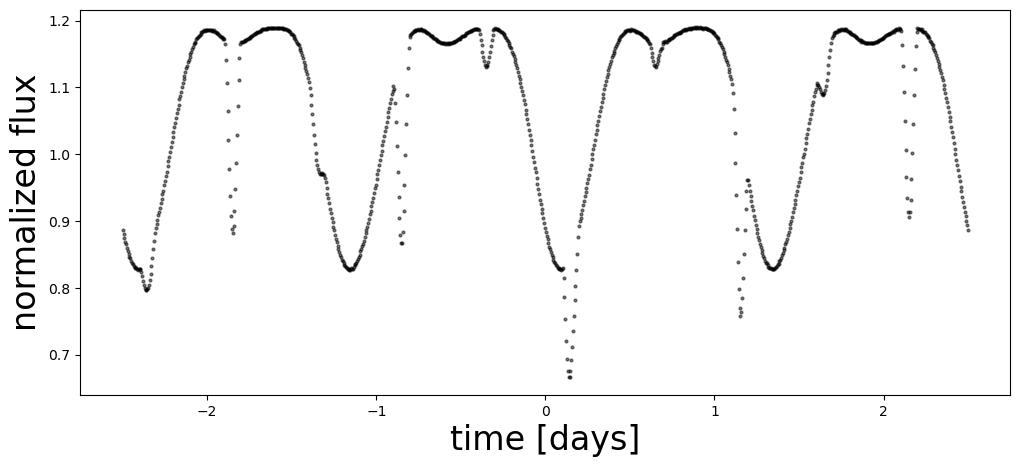

In [7]:
# Lightcurve to run inference on
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.5, ms=4)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

In [8]:
# Prior on primary
pri_mu = np.zeros(pri.map.Ny)
pri_mu[0] = 1.0
pri_L = np.zeros(pri.map.Ny)
pri_L[0] = 1e-2
pri_L[1:] = 1e-2
pri.map.set_prior(mu=pri_mu, L=pri_L)

# Prior on secondary
sec_mu = np.zeros(sec.map.Ny)
sec_mu[0] = 0.1
sec_L = np.zeros(sec.map.Ny)
sec_L[0] = 1e-4
sec_L[1:] = 1e-4
sec.map.set_prior(mu=sec_mu, L=sec_L)

In [9]:
sys.set_data(flux, C=sigma ** 2)

In [10]:
mu, cho_cov = sys.solve(t=t)

In [11]:
sys.draw()

In [12]:
pri.map.show(theta=np.linspace(0, 360, 50))

In [13]:
sec.map.show(theta=np.linspace(0, 360, 50))

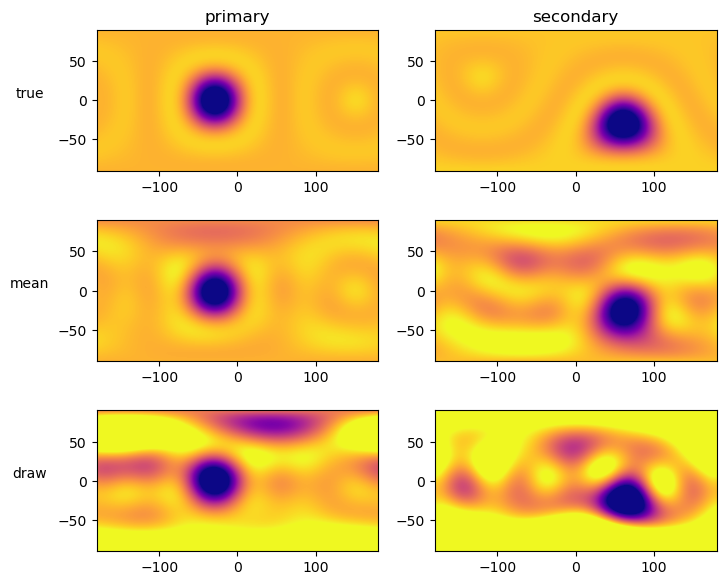

In [14]:
# true values
pri.map[1:, :] = A["y"]
pri.map.amp = A["amp"]
pri_true = pri.map.render(projection="rect")
sec.map[1:, :] = B["y"]
sec.map.amp = B["amp"]
sec_true = sec.map.render(projection="rect")

# mean values
pri.map.amp = mu[0]
pri.map[1:, :] = mu[1 : pri.map.Ny] / pri.map.amp
pri_mu = pri.map.render(projection="rect")
sec.map.amp = mu[pri.map.Ny]
sec.map[1:, :] = mu[pri.map.Ny + 1 :] / sec.map.amp
sec_mu = sec.map.render(projection="rect")

# a random draw
sys.draw()
pri_draw = pri.map.render(projection="rect")
sec_draw = sec.map.render(projection="rect")

fig, ax = plt.subplots(3, 2, figsize=(8, 7))
ax[0, 0].imshow(
    pri_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[1, 0].imshow(
    pri_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[2, 0].imshow(
    pri_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[0, 1].imshow(
    sec_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[1, 1].imshow(
    sec_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[2, 1].imshow(
    sec_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[0, 0].set_title("primary")
ax[0, 1].set_title("secondary")
ax[0, 0].set_ylabel("true", rotation=0, labelpad=20)
ax[1, 0].set_ylabel("mean", rotation=0, labelpad=20)
ax[2, 0].set_ylabel("draw", rotation=0, labelpad=20);

Reconstructng with a single transit

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import starry
from scipy.linalg import cho_solve
from corner import corner

import theano
theano.config.gcc__cxxflags += " -fexceptions"

np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True


data = np.load("../eb.npz", allow_pickle=True)
A = data["A"].item()
B = data["B"].item()
t = data["t"]
flux = data["flux"]
sigma = data["sigma"]


# Primary
pri = starry.Primary(
    starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=A["inc"]),
    r=A["r"],
    m=A["m"],
    prot=A["prot"],
)
pri.map[1:] = A["u"]

# Secondary
sec = starry.Secondary(
    starry.Map(ydeg=B["ydeg"], udeg=B["udeg"], inc=B["inc"]),
    r=B["r"],
    m=B["m"],
    porb=B["porb"],
    prot=B["prot"],
    t0=B["t0"],
    inc=B["inc"],
)
sec.map[1:] = B["u"]

# System
sys = starry.System(pri, sec)

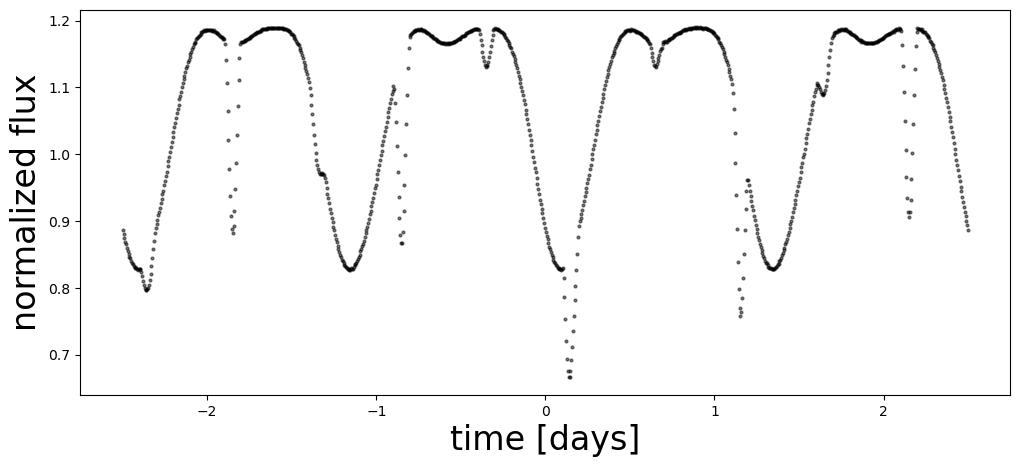

In [17]:
# Lightcurve to run inference on
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.plot(t, flux, "k.", alpha=0.5, ms=4)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

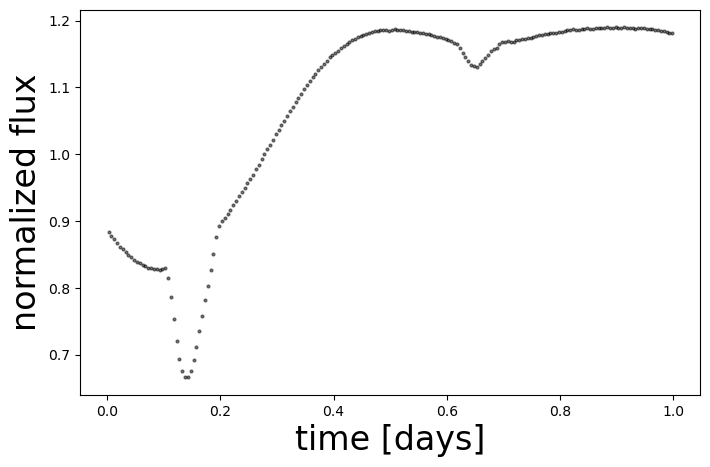

In [18]:
t_single=t[(t>=0)&(t<=1)]
flux_single=flux[(t>=0)&(t<=1)]

fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.plot(t_single,flux_single,'k.',alpha=0.5,ms=4)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

In [19]:
# Prior on primary
pri_mu = np.zeros(pri.map.Ny)
pri_mu[0] = 1.0
# # Primary star
# map_prior = starry.Map(ydeg=5)
# map_prior.add_spot(amp=-0.075, sigma=0.1, lat=30, lon=-60)
# A_y = np.array(map_prior.y[1:])
# pri_mu=np.append(1.0, A_y)

# map_prior.show()


pri_L = np.zeros(pri.map.Ny)
pri_L[0] = 1e-2
pri_L[1:] = 1e-2
pri.map.set_prior(mu=pri_mu, L=pri_L)

# Prior on secondary
sec_mu = np.zeros(sec.map.Ny)
sec_mu[0] = 0.1
sec_L = np.zeros(sec.map.Ny)
sec_L[0] = 1e-4
sec_L[1:] = 1e-4
sec.map.set_prior(mu=sec_mu, L=sec_L)



# temp_initial_pri_amp = pri.map.amp
# temp_initial_pri_y = pri.map[1:, :].copy()
# temp_initial_sec_amp = sec.map.amp
# temp_initial_sec_amp = sec.map[1:, :].copy()


In [20]:
sys.set_data(flux_single, C=sigma ** 2)
mu, cho_cov = sys.solve(t=t_single)
sys.draw()

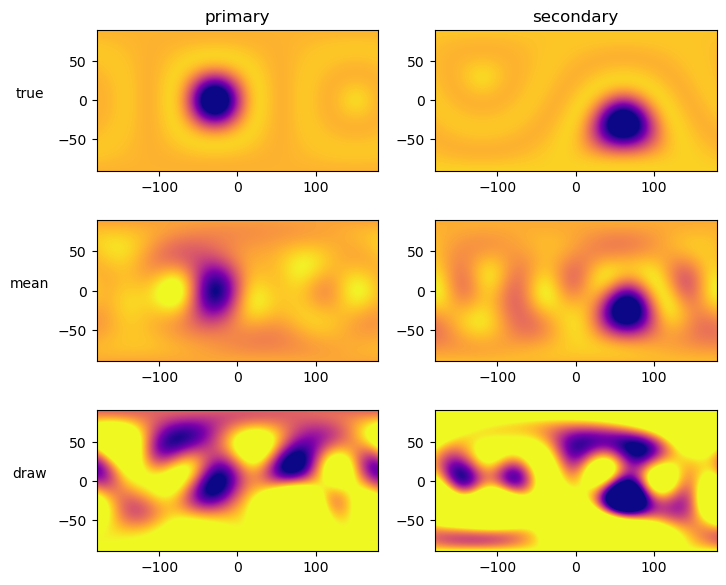

In [21]:
# true values
pri.map[1:, :] = A["y"]
pri.map.amp = A["amp"]
pri_true = pri.map.render(projection="rect")
sec.map[1:, :] = B["y"]
sec.map.amp = B["amp"]
sec_true = sec.map.render(projection="rect")

# mean values
pri.map.amp = mu[0]
pri.map[1:, :] = mu[1 : pri.map.Ny] / pri.map.amp
pri_mu = pri.map.render(projection="rect")
sec.map.amp = mu[pri.map.Ny]
sec.map[1:, :] = mu[pri.map.Ny + 1 :] / sec.map.amp
sec_mu = sec.map.render(projection="rect")

# a random draw
sys.draw()
pri_draw = pri.map.render(projection="rect")
sec_draw = sec.map.render(projection="rect")

fig, ax = plt.subplots(3, 2, figsize=(8, 7))
ax[0, 0].imshow(
    pri_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[1, 0].imshow(
    pri_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[2, 0].imshow(
    pri_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[0, 1].imshow(
    sec_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[1, 1].imshow(
    sec_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[2, 1].imshow(
    sec_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[0, 0].set_title("primary")
ax[0, 1].set_title("secondary")
ax[0, 0].set_ylabel("true", rotation=0, labelpad=20)
ax[1, 0].set_ylabel("mean", rotation=0, labelpad=20)
ax[2, 0].set_ylabel("draw", rotation=0, labelpad=20);

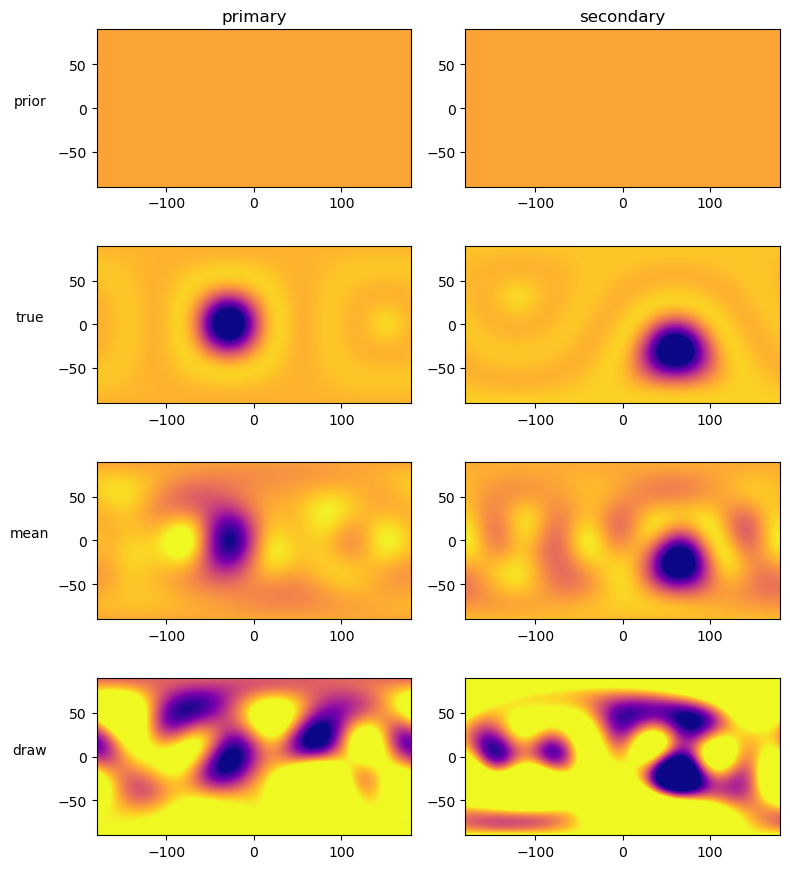

In [22]:
# 1. Save the current (posterior) amp and spherical harmonic coefficients so we can revert.
temp_amp_pri = pri.map.amp
temp_y_pri = pri.map[1:, :].copy()
temp_amp_sec = sec.map.amp
temp_y_sec = sec.map[1:, :].copy()

# 2. Overwrite the map with the prior mean parameters, then render.
# Primary
pri.map.amp = 1  # from pri_mu[0]
pri.map[1:, :] = 0   # all higher-order terms zero in the prior mean
pri_prior = pri.map.render(projection="rect")

# Secondary
sec.map.amp = 0.1       # from sec_mu[0]
sec.map[1:, :] = 0.0
sec_prior = sec.map.render(projection="rect")

# 3. Revert the map back to its previous (posterior) state.
pri.map.amp = temp_amp_pri
pri.map[1:, :] = temp_y_pri
sec.map.amp = temp_amp_sec
sec.map[1:, :] = temp_y_sec

# -------------------------------------------------
# Now pri_true, pri_mu, pri_draw (and similarly for sec)
# can be the same as in your original code:
#
#   pri_true  = ...
#   pri_mu    = ...
#   pri_draw  = ...
#   sec_true  = ...
#   sec_mu    = ...
#   sec_draw  = ...
#
# -------------------------------------------------

fig, ax = plt.subplots(4, 2, figsize=(8, 9))

# ---------------------
# Row 0: Prior
ax[0, 0].imshow(
    pri_prior,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[0, 1].imshow(
    sec_prior,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)

ax[0, 0].set_title("primary")
ax[0, 1].set_title("secondary")
ax[0, 0].set_ylabel("prior", rotation=0, labelpad=20)

# ---------------------
# Row 1: True
ax[1, 0].imshow(
    pri_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[1, 1].imshow(
    sec_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[1, 0].set_ylabel("true", rotation=0, labelpad=20)

# ---------------------
# Row 2: Mean
ax[2, 0].imshow(
    pri_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[2, 1].imshow(
    sec_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[2, 0].set_ylabel("mean", rotation=0, labelpad=20)

# ---------------------
# Row 3: Draw
ax[3, 0].imshow(
    pri_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[3, 1].imshow(
    sec_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[3, 0].set_ylabel("draw", rotation=0, labelpad=20)

plt.tight_layout()
plt.show()


Trying to reconstruct with a single transit and a prior that has changed

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import starry
from scipy.linalg import cho_solve
from corner import corner

import theano
theano.config.gcc__cxxflags += " -fexceptions"

np.random.seed(12)
starry.config.lazy = False
starry.config.quiet = True


data = np.load("eb.npz", allow_pickle=True)
A = data["A"].item()
B = data["B"].item()
t = data["t"]
flux = data["flux"]
sigma = data["sigma"]


# Primary
pri = starry.Primary(
    starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=A["inc"]),
    r=A["r"],
    m=A["m"],
    prot=A["prot"],
)
pri.map[1:] = A["u"]

# Secondary
sec = starry.Secondary(
    starry.Map(ydeg=B["ydeg"], udeg=B["udeg"], inc=B["inc"]),
    r=B["r"],
    m=B["m"],
    porb=B["porb"],
    prot=B["prot"],
    t0=B["t0"],
    inc=B["inc"],
)
sec.map[1:] = B["u"]

# System
sys = starry.System(pri, sec)

FileNotFoundError: [Errno 2] No such file or directory: 'eb.npz'

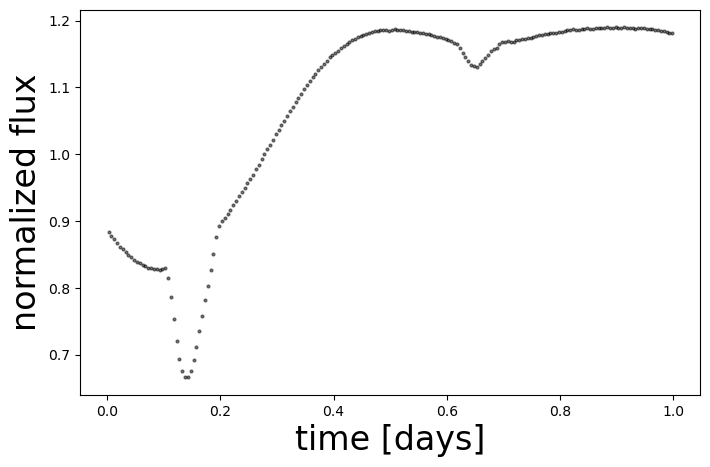

In [ ]:
t_single=t[(t>=0)&(t<=1)]
flux_single=flux[(t>=0)&(t<=1)]

fig,ax=plt.subplots(1,1,figsize=(8,5))
ax.plot(t_single,flux_single,'k.',alpha=0.5,ms=4)
ax.set_xlabel("time [days]", fontsize=24)
ax.set_ylabel("normalized flux", fontsize=24);

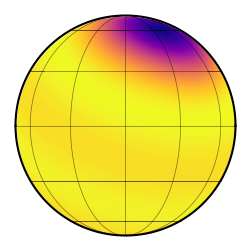

In [ ]:
# Primary star
map_prior = starry.Map(ydeg=5)
map_prior.add_spot(amp=-0.075, sigma=0.1, lat=60, lon=40)
A_y = np.array(map_prior.y[1:])
# pri_mu=np.append(1.0, A_y)

map_prior.show()

In [ ]:
# Prior on primary
pri_mu=np.append(1.0, A_y)
pri_L = np.zeros(pri.map.Ny)
# pri_L[0] = 1e-2
# pri_L[1:] = 1e-2
pri_L[0] = 1e-4
pri_L[1:] = 1e-4
pri.map.set_prior(mu=pri_mu, L=pri_L)
pri_prior_render=pri.map.render(projection="rect")

# Prior on secondary
sec_mu = np.zeros(sec.map.Ny)
sec_mu[0] = 0.1
sec_L = np.zeros(sec.map.Ny)
sec_L[0] = 1e-4
sec_L[1:] = 1e-4
sec.map.set_prior(mu=sec_mu, L=sec_L)
sec_prior_render=sec.map.render(projection="rect")


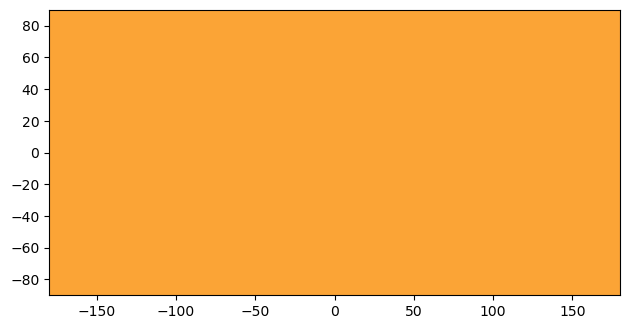

In [ ]:
plt.imshow(
    pri_prior_render,  # Use the prior render from the modified pri map with spot
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
plt.tight_layout()
plt.show()

In [ ]:
sys.set_data(flux_single, C=sigma ** 2)
mu, cho_cov = sys.solve(t=t_single)
sys.draw()

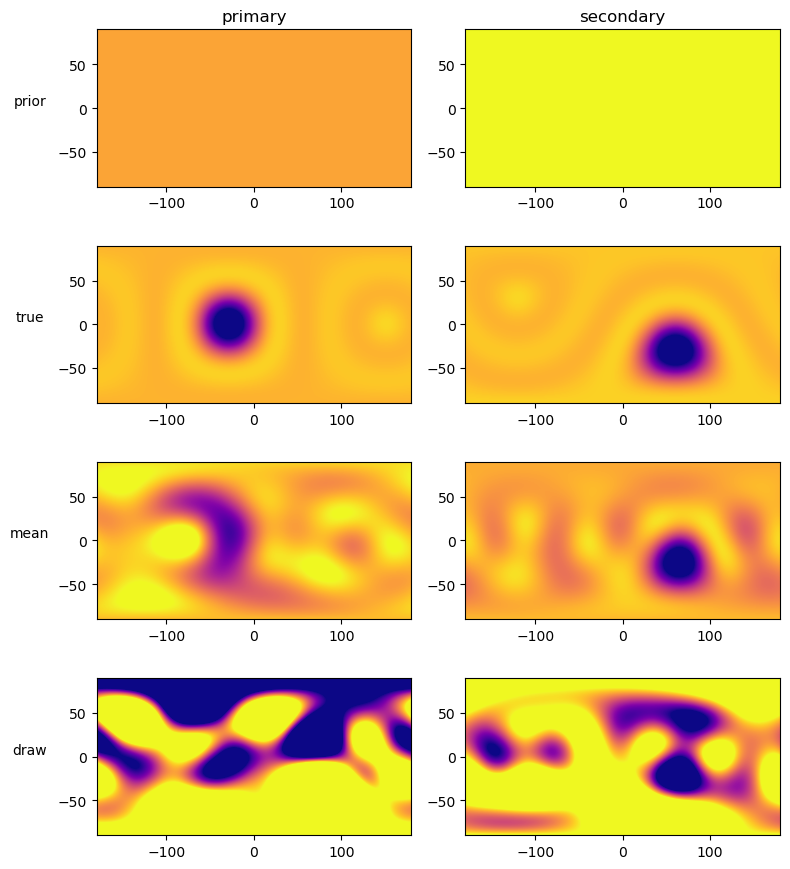

In [ ]:
# true values
pri.map[1:, :] = A["y"]
pri.map.amp = A["amp"]
pri_true = pri.map.render(projection="rect")
sec.map[1:, :] = B["y"]
sec.map.amp = B["amp"]
sec_true = sec.map.render(projection="rect")

# mean values
pri.map.amp = mu[0]
pri.map[1:, :] = mu[1 : pri.map.Ny] / pri.map.amp
pri_mu = pri.map.render(projection="rect")
sec.map.amp = mu[pri.map.Ny]
sec.map[1:, :] = mu[pri.map.Ny + 1 :] / sec.map.amp
sec_mu = sec.map.render(projection="rect")

# a random draw
sys.draw()
pri_draw = pri.map.render(projection="rect")
sec_draw = sec.map.render(projection="rect")

fig, ax = plt.subplots(4, 2, figsize=(8, 9))

# ---------------------
# Row 0: Prior
ax[0, 0].imshow(
    pri_prior_render,  # Use the prior render from the modified pri map with spot
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[0, 1].imshow(
    sec_prior_render,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)

ax[0, 0].set_title("primary")
ax[0, 1].set_title("secondary")
ax[0, 0].set_ylabel("prior", rotation=0, labelpad=20)

# ---------------------
# Row 1: True
ax[1, 0].imshow(
    pri_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[1, 1].imshow(
    sec_true,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[1, 0].set_ylabel("true", rotation=0, labelpad=20)

# ---------------------
# Row 2: Mean
ax[2, 0].imshow(
    pri_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[2, 1].imshow(
    sec_mu,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[2, 0].set_ylabel("mean", rotation=0, labelpad=20)

# ---------------------
# Row 3: Draw
ax[3, 0].imshow(
    pri_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.4,
)
ax[3, 1].imshow(
    sec_draw,
    origin="lower",
    extent=(-180, 180, -90, 90),
    cmap="plasma",
    vmin=0,
    vmax=0.04,
)
ax[3, 0].set_ylabel("draw", rotation=0, labelpad=20)

plt.tight_layout()
plt.show()
